## Code

### Libs

In [255]:
import os
from zipfile import ZipFile
from os.path import isfile, join
import math
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, confusion_matrix

### Bayes class

In [256]:
class Bayes(BaseEstimator):
    def __init__(self, alpha=1, lambdas=[1, 1]):
        cnt = len(lambdas)
        self.alpha = alpha
        self.lambdas = lambdas
        self.classes_cnt = cnt
        
    def fit(self, X, y):
        self.labels = np.unique(y)
        self.total_counts = np.sum(X, axis=0)
        self.label_probas = np.zeros(self.labels.shape[0])
        self.word_probas = np.zeros((self.labels.shape[0], self.total_counts.shape[0]))

        for label in self.labels:
            self.word_probas[label] = np.sum(X[y == label], axis=0) + self.alpha
            self.word_probas[label] /= self.alpha * X.shape[1] + np.sum(X[y == label])
            self.label_probas[label] = float(y[y == label].shape[0]) / y.shape[0]

    def predict_raw(self, X):
        label_probas = np.zeros((X.shape[0], self.labels.shape[0]))
        self.labels_weights = np.ones((self.labels.shape[0],)) if self.lambdas is None else self.lambdas

        for i in np.arange(0, X.shape[0]):
            for label in self.labels:
                label_probas[i][label] = np.log(self.labels_weights[label] * self.label_probas[label]) \
                + np.sum(np.log(self.word_probas[label][X[i] != 0]))

        return label_probas

    def predict_proba(self, X):
        label_log_probas = self.predict_raw(X)

        for i in np.arange(0, X.shape[0]):
            label_log_probas[i] = [
                1 / (1 + np.exp(label_log_probas[i][1] - label_log_probas[i][0])),
                1 / (1 + np.exp(label_log_probas[i][0] - label_log_probas[i][1]))
            ]

        return label_log_probas

    def predict(self, X):
        return np.argmax(self.predict_raw(X), axis=1)

### Data Process

In [257]:
def getDatasetPartName(n):
    return 'messages/part' + str(n)

In [258]:
with ZipFile('messages.zip', 'r') as zip:
  zip.extractall()
  print('ok')

ok


In [259]:
messages = []
for i in range(10):
    for cur_file in os.listdir(getDatasetPartName(i + 1)):
        message_file = open(getDatasetPartName(i + 1) + "/" + cur_file, "r")
        subject = message_file.readline()[9:-1]
        message_file.readline()
        text = message_file.readline()[:-1]
        is_spam = 1 if 'spmsg' in cur_file else 0

        messages.append([subject, text, is_spam])

In [260]:
messages = pd.DataFrame(messages, columns=['subject', 'text', 'spam'])
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(messages['subject'] + ' ' + messages['text']).toarray()
y = messages['spam']

### Model Scoring

In [261]:
scoring = { 'accuracy': make_scorer(accuracy_score),'f1_score': make_scorer(f1_score)}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp


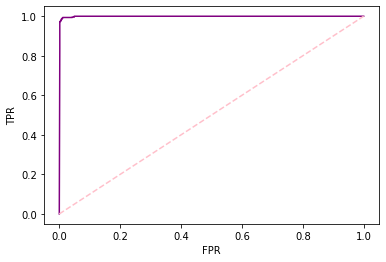

In [262]:
spam_classifier = Bayes()
spam_classifier.fit(X, y)
y_pred_proba = spam_classifier.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='purple', label='ROC val')
plt.plot([0, 1], [0, 1], color='pink', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Optimal lamda detection

In [263]:
def class_accuracy(y, y_pred, label):
    y_labels = y[y == label]
    y_pred_labels = y_pred[y == label]
    return float(np.sum(y_labels == y_pred_labels)) / y_labels.shape[0]

In [264]:
f1_scores = []
ok_accuracy = []
spam_accuracy = []
power = 0
fp = -1
while fp != 0:
    spam_classifier = Bayes(lambdas=[10 ** power, 1])
    spam_classifier.fit(X, y)

    y_pred = spam_classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("%2d: TN = %3d, FP = %2d, FN = %2d, TP = %3d" % (power, tn, fp, fn, tp))
    f1_scores.append(f1_score(y, y_pred))
    ok_accuracy.append(class_accuracy(y, y_pred, 0))
    spam_accuracy.append(class_accuracy(y, y_pred, 1))
    power += 1

 0: TN = 596, FP = 14, FN =  3, TP = 477
 1: TN = 599, FP = 11, FN =  3, TP = 477
 2: TN = 601, FP =  9, FN =  3, TP = 477
 3: TN = 604, FP =  6, FN =  4, TP = 476
 4: TN = 604, FP =  6, FN =  5, TP = 475
 5: TN = 605, FP =  5, FN =  6, TP = 474
 6: TN = 607, FP =  3, FN = 11, TP = 469
 7: TN = 609, FP =  1, FN = 14, TP = 466
 8: TN = 609, FP =  1, FN = 19, TP = 461
 9: TN = 609, FP =  1, FN = 34, TP = 446
10: TN = 609, FP =  1, FN = 41, TP = 439
11: TN = 609, FP =  1, FN = 52, TP = 428
12: TN = 609, FP =  1, FN = 55, TP = 425
13: TN = 609, FP =  1, FN = 57, TP = 423
14: TN = 609, FP =  1, FN = 63, TP = 417
15: TN = 609, FP =  1, FN = 73, TP = 407
16: TN = 609, FP =  1, FN = 80, TP = 400
17: TN = 609, FP =  1, FN = 88, TP = 392
18: TN = 609, FP =  1, FN = 99, TP = 381
19: TN = 610, FP =  0, FN = 107, TP = 373


## Results

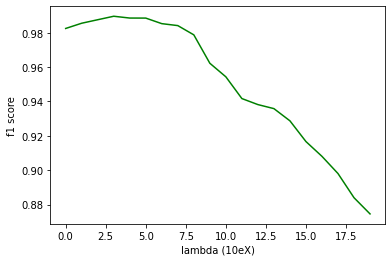

In [265]:
plt.plot(f1_scores, 'g-')
plt.xlabel('lambda (10eX)')
plt.ylabel('f1 score')
plt.show()

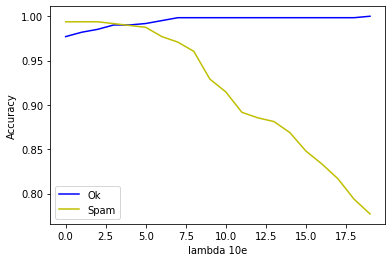

In [266]:
plt.plot(ok_accuracy, 'b-', spam_accuracy, 'y-')
plt.xlabel('lambda 10e')
plt.ylabel('Accuracy')
plt.legend(['Ok', 'Spam'])
plt.show()